In [1]:
# Install Libraries
!pip install tensorflow keras opencv-python scikit-learn matplotlib

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_SIZE = 224
BATCH_SIZE = 32

# Path to the dataset
dataset_path = r'C:\Users\Jayath Kasiwaththa\Downloads\archive\garbage_classification'

# Categories (classes) of garbage (optional, for reference)
categories = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass',
              'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

# Apply data augmentation to the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the images
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # Split the data into 80% training and 20% validation
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create the training generator with augmentation
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize all images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='sparse',  
    subset='training' 
)

# Create the validation generator without augmentation
validation_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),  
    batch_size=BATCH_SIZE,
    class_mode='sparse', 
    subset='validation' 
)

# Shape of the training and validation batches
print(f"Training data: {train_generator.samples} samples")
print(f"Validation data: {validation_generator.samples} samples")

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Training data: 12415 samples
Validation data: 3100 samples


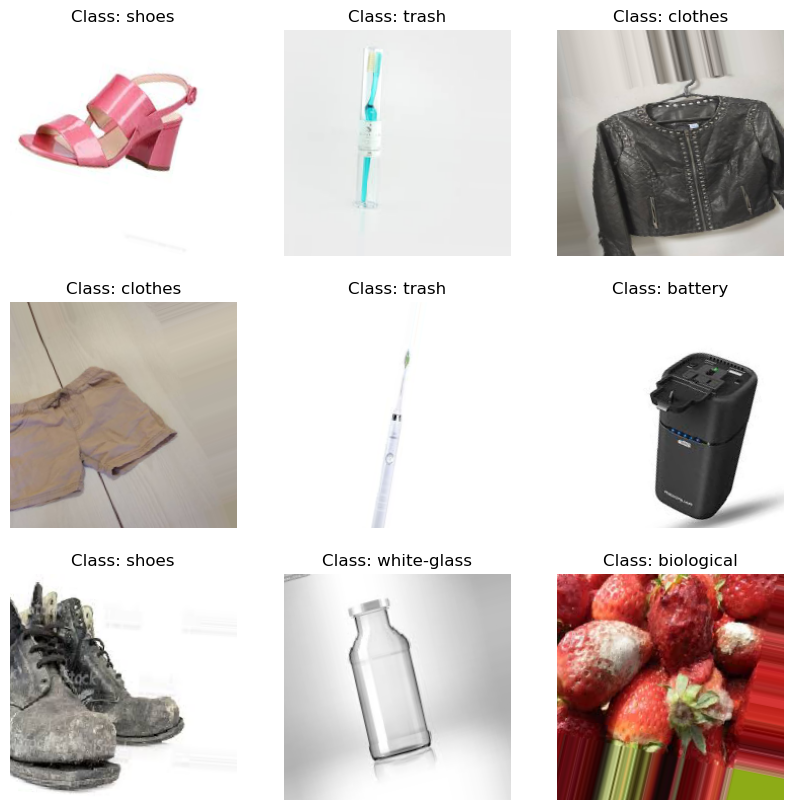

In [4]:
# Display some augmented images
augmented_images, augmented_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Class: {categories[int(augmented_labels[i])]}")
    plt.axis('off')
plt.show()

#InceptionV3

In [5]:
#Libries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Image dimensions and batch size
IMG_SIZE = 224  # Keeping it consistent with your preprocessing
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

# Path to the dataset
dataset_path = r'C:\Users\Jayath Kasiwaththa\Downloads\archive\garbage_classification'

# Data augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

# Load the pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add hidden layers
x = Dense(1024, activation='relu')(x)  # First hidden layer
x = Dense(512, activation='relu')(x)   # Second hidden layer
x = Dense(256, activation='relu')(x)   # Third hidden layer

# Output layer for classification
predictions = Dense(12, activation='softmax')(x)  # 12 classes for garbage classification

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base InceptionV3 layers to avoid retraining
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Save the trained model
model.save('garbage_classification_inceptionv3.h5')

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
Epoch 1/20


C:\Users\Jayath Kasiwaththa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


387/387 ━━━━━━━━━━━━━━━━━━━━ 375s 947ms/step - accuracy: 0.7281 - loss: 0.8855 - val_accuracy: 0.8665 - val_loss: 0.4046
Epoch 2/20
  1/387 ━━━━━━━━━━━━━━━━━━━━ 5:12 809ms/step - accuracy: 0.8750 - loss: 0.3474

C:\Users\Jayath Kasiwaththa\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8750 - loss: 0.3474 - val_accuracy: 0.8929 - val_loss: 0.3416
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 352s 903ms/step - accuracy: 0.8901 - loss: 0.3471 - val_accuracy: 0.8883 - val_loss: 0.3271
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9062 - loss: 0.3336 - val_accuracy: 0.9643 - val_loss: 0.1571
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 344s 883ms/step - accuracy: 0.9055 - loss: 0.2926 - val_accuracy: 0.8743 - val_loss: 0.3894
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8750 - loss: 0.3066 - val_accuracy: 0.9643 - val_loss: 0.1308
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 377s 970ms/step - accuracy: 0.9141 - loss: 0.2598 - val_accuracy: 0.8812 - val_loss: 0.3629
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.3591 - val_accuracy: 1.0000 - val_loss: 0.0793
Epoch 9/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 363s 933ms/step - accuracy: 0.9243 - loss: 0.2253 - val_accurac

97/97 ━━━━━━━━━━━━━━━━━━━━ 56s 576ms/step - accuracy: 0.9040 - loss: 0.2900
Validation Accuracy: 91.42%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

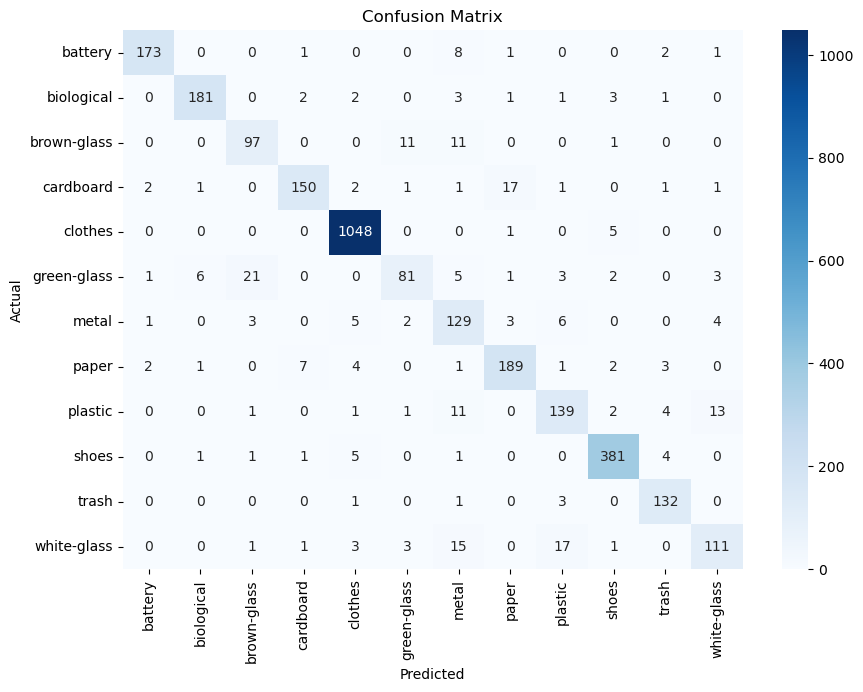

Test Accuracy: 91.50%


In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model('garbage_classification_inceptionv3.h5')

# Reset validation generator
validation_generator.reset()

# Initialize lists to store predictions and actual classes
y_prob = []
y_act = []
nb_samples = validation_generator.samples // BATCH_SIZE

# Loop through the test data
for _ in range(nb_samples):
    X_test, y_test = next(validation_generator)
    y_prob.append(model.predict(X_test))
    y_act.append(y_test)

# Flatten the lists to remove batch dimensions
y_prob = np.vstack(y_prob)  # Stack predictions into a single array
y_act = np.hstack(y_act)    # Stack true labels into a single array

# Convert predicted probabilities to predicted classes
predicted_class = [list(validation_generator.class_indices.keys())[np.argmax(i)] for i in y_prob]
actual_class = [list(validation_generator.class_indices.keys())[int(i)] for i in y_act]  # Convert y_act to integer classes

# Create a DataFrame for the actual vs predicted classes
out_df = pd.DataFrame({'predicted_class': predicted_class, 'actual_class': actual_class})

# Generate confusion matrix
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.diag(confusion_matrix).sum() / confusion_matrix.sum().sum() * 100
print(f'Test Accuracy: {accuracy:.2f}%')
